In [1]:
%matplotlib inline
from IPython.display import clear_output
from utils import *         # Holds some helper functions to help with loading images etc
import numpy as np
import matplotlib.pyplot as plt
from random import choice
# import matplotlib
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
# import matplotlib.image as matimg
from skimage.transform import resize
from PIL import Image
#from scipy.misc import imresize, toimage
import os
# import cv2
from scipy.stats import norm
import glob
# from mouseinput import LatentSpaceWalker

from keras.layers import Dense, Lambda, Flatten, Reshape, Dropout
from keras.layers import Conv2DTranspose, Input
#from keras.engine.topology import Input
from keras.layers.convolutional import Conv2D
from keras.models import Model
from keras import optimizers
from keras import backend as K
from keras import objectives
from keras.callbacks import ModelCheckpoint as SaveModelCallback
from keras.utils import to_categorical

/home/jp/anaconda3/envs/conv-vae/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load Images and plot some examples

In [2]:
base_dir = '../data/gray_80_80_annotated/'
image_dir = base_dir + 'images/'
anno_dir  = base_dir + 'annotations/'
train_names, test_names = get_data_point_names(image_dir, anno_dir)

# x_train = rgb2gray(x_train_clr)
# x_test= rgb2gray(x_test_clr)
# # x_train = x_train_clr
# # x_test  = x_test_clr

# def PlotExampleImages(data, num_examples=10):
#     plt.figure(1)
#     # plt.figure(figsize=(10,1))
#     for i in range(num_examples):
#         r = 1
#         c = num_examples
#         ax = plt.subplot(r, c, i+1)
#         to_plot = choice(data)
#         if np.shape(to_plot)[2] == 1:              # only 1 color channel, therefore gray scale
#             to_plot = choice(data[:,:,:,0])
#             plt.imshow(to_plot,cmap = plt.get_cmap('gray'))
#         else:
#             plt.imshow(choice(data))
            
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)
        
# PlotExampleImages(x_train)

### House keeping

In [3]:
def norm_data(images):
    result = images.astype('float32') / 255.
    return result

def pre_process_annos(annos):
    # Maps from (0 to 1024) to (-1 to +1)
    processed = []
    for an in annos:
        proc_anno = np.array(an['steering'])
#         print("an: {}".format(proc_anno))
        processed.append( [((proc_anno / 1024.) - 0) * 1.])
    return np.array(processed)

def pre_process(images, annos):
    '''
    Mirror randomly, add some noise, pick up milk.
    '''
    _annos = pre_process_annos(annos)
    proc_annos = []
    proc_images = []
    for i,a in zip(images, _annos):
        if random.uniform(0.,1.) < 0.5:
            i = np.flip(i, 1)
            a *= -1.
        
        # Bin the steering angles
        if   a < -0.2: 
            a = 0
        elif a >  0.2: 
            a = 2
        else:
            a = 1
        proc_annos.append(a)
        proc_images.append(i)
        
    proc_images = np.array(proc_images)
    proc_images = np.expand_dims(proc_images, axis=3)
    return proc_images, proc_annos

# from keras.utils import Sequence
class DataGenerator():
    
    def __init__(self, batch_size, data_names, image_dir, anno_dir, debug=None):
        np.random.shuffle(data_names)
        to_remove = len(data_names) % batch_size
        _names = data_names
        if to_remove != 0:
            _names = data_names[:-to_remove]
            print("Warning! number of training samples ({}) is not divisable \
                   by batch_size ({})".format(len(data_names), batch_size))
            print("Removing {} samples from data set.".format(to_remove))
            print("UPDATED: shape: {}".format(np.shape(_names)))
        
        self.data_names      = _names
        self.batch_size      = batch_size
        self.image_dir       = image_dir
        self.anno_dir        = anno_dir
        self.steps_per_epoch = len(self.data_names) // self.batch_size
        self.current_step    = 0
        self.debug           = debug
        
    def out_of_data(self):
        return self.current_step >= self.steps_per_epoch
    
    def steps_per_epoch(self):
        return self.steps_per_epoch
    
    def get_next_batch(self):
        #print("step {} of {}".format(self.current_step, self.steps_per_epoch))
        if self.current_step == self.steps_per_epoch:
            print("Data source exhausted, re-init DataGenerator")
            return None, None
        
        i = self.current_step * self.batch_size
        im_paths = []
        an_paths = []
        for ele in range(self.batch_size):
            name = self.data_names[i+ele]
            im_paths.append(image_dir + name + ".jpg")
            an_paths.append(anno_dir  + name + ".txt")
        
        images, annos = load_samples(im_paths, an_paths)
        
#         DEBUG
#         w = np.ones((80,40)) * 255.
#         b = np.zeros((80,40))
#         bw = np.concatenate((w,b), axis=1)
#         images = [bw,]*batch_size
#         annos = [{'steering': 1.}]*batch_size
        
        proc_images, proc_annos = pre_process(images, annos)
        #print(np.shape(proc_images))
        
        self.current_step += 1
        return proc_images, proc_annos



In [4]:
my_data=DataGenerator(10, train_names[:50], image_dir, anno_dir)

len:  10
shape: (80, 80, 1)
shape: (80, 80, 1)
shape: (80, 80, 1)
shape: (80, 80, 1)
shape: (80, 80, 1)
shape: (80, 80, 1)
shape: (80, 80, 1)
shape: (80, 80, 1)
shape: (80, 80, 1)
shape: (80, 80, 1)


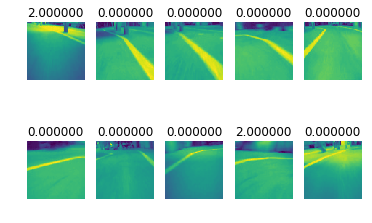

In [5]:
images, annos = my_data.get_next_batch()
print("len: ", len(annos))
for i, (im, an) in enumerate(zip(images, annos)):
    plot = i+1
    plt.subplot(2,5,plot)
    print("shape: {}".format(np.shape(im)))
    plt.imshow(im[:,:,0])
    plt.axis('off')
    # Covert to +- 100% for hard left or hard right 
    angle = an
    plt.title("{:2f}".format(angle))


### Some hyperparams

In [6]:
epochs           = 5
input_shape      = (80,80,1)
num_chans        = 1
batch_size       = 50

input_dim        = np.prod(input_shape)  # flattened size of input_image
intermediate_dim = 255
intermediate_dim = 50
out_dim          = 3
learning_rate    = 0.001
optimizer        = optimizers.Adam(lr=learning_rate)  

# for more optimizers (https://keras.io/optimizers/)

### Defining the model

In [7]:
# building model (using keras syntax)
# ENCODER
# model = Sequential()
# model.add(Conv2D(8, (3,3),
#                      activation='relu',
#                      input_shape=input_shape,
#                      border_mode='same')
enc_input = Input(input_shape)
enc_conv_1  = Conv2D(16, kernel_size=(3,3),
                     activation='relu',
                     padding='same')(enc_input) 
enc_conv_2  = Conv2D(32, kernel_size=(2,2), strides=(2,2),
                     activation='relu',
                     padding='same')(enc_conv_1) 
enc_conv_3  = Conv2D(64, kernel_size=(2,2), strides=(2,2),
                     activation='relu',
                     padding='same')(enc_conv_2) 
#see kernel initializers
# enc_conv_2  = Conv2d(16, (2,2), strides=(2,2), activation='relu')(enc_conv_1)
enc_flat = Flatten()(enc_conv_3)
enc_fc1  = Dense(intermediate_dim, activation='relu')(enc_flat)
dr_1     = Dropout(0.25)(enc_fc1)
enc_fc2  = Dense(intermediate_dim, activation='relu')(dr_1)
dr_2     = Dropout(0.5)(enc_fc2)
output   = Dense(out_dim, activation='softmax')(dr_2)
driver   = Model(enc_input, output)
driver.compile(optimizer=optimizer,
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [8]:
def Train(model, epochs, batch_size, train_names, test_names, image_dir, anno_dir):
    loss_plot = []
    model.reset_states()
    for e in range(epochs):
        train_gen = DataGenerator(batch_size, train_names, image_dir, anno_dir)
        test_gen  = DataGenerator(batch_size, test_names, image_dir, anno_dir)
        print("\nEPOCH: {}\n-----Train-----".format(e))
        
        count = 0
        while not train_gen.out_of_data():
            x,y, = train_gen.get_next_batch()
            y = to_categorical(y)
            loss = model.fit(x,y,batch_size,verbose=0)
            loss = loss.history['loss']
            count += 1
            loss_plot.append(loss)
            if count%50 == 0:
                print("Step: {}, loss: {}".format(count, loss))
#                 plt.subplot(111)
#                 plt.plot(loss_plot)
#                 plt.show()
            
        print("-----EVAL-----")
        loss = []
        accur = []
        while not test_gen.out_of_data():
            x,y, = test_gen.get_next_batch()
            y = to_categorical(y)
            l,a = model.evaluate(x,y,batch_size, verbose=0)
            loss.append(l)
            accur.append(a)
            
        print("-----Results-----")
        print("loss: {}, accur: {}".format(np.mean(loss), np.mean(accur)))
        

In [9]:
checkpoint_path = "./testpoint"

'''
fit_generator(self, generator, steps_per_epoch=None, 
epochs=1, verbose=1, callbacks=None, validation_data=None, 
validation_steps=None, class_weight=None, max_queue_size=10, 
workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)
'''


Train(driver,
      epochs,
      batch_size,
      train_names,
      test_names,
      image_dir,
      anno_dir)

Warning! number of training samples (13857) is not divisable                    by batch_size (50)
Removing 7 samples from data set.
UPDATED: shape: (13850,)
Warning! number of training samples (5940) is not divisable                    by batch_size (50)
Removing 40 samples from data set.
UPDATED: shape: (5900,)

EPOCH: 0
-----Train-----
Step: 50, loss: [0.8660781979560852]
Step: 100, loss: [0.7059746384620667]
Step: 150, loss: [0.5013620257377625]
Step: 200, loss: [0.5966421365737915]
Step: 250, loss: [0.41961297392845154]
-----EVAL-----
-----Results-----
loss: 0.3191561936321905, accur: 0.8574576206126455
Warning! number of training samples (13857) is not divisable                    by batch_size (50)
Removing 7 samples from data set.
UPDATED: shape: (13850,)
Warning! number of training samples (5940) is not divisable                    by batch_size (50)
Removing 40 samples from data set.
UPDATED: shape: (5900,)

EPOCH: 1
-----Train-----
Step: 50, loss: [0.26960963010787964]
Step:

### Function to encode a list of input images


len:  10


/home/jp/anaconda3/envs/conv-vae/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(-0.54, 2.5400000000000005, 0.0, 1.05)

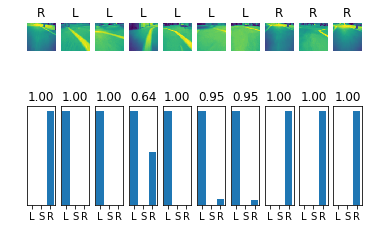

In [29]:
my_data=DataGenerator(10, train_names[:50], image_dir, anno_dir)
images, annos = my_data.get_next_batch()
probs = driver.predict(images)
classes = ['L', 'S', 'R']
y_pos = np.arange(len(classes))
print("len: ", len(annos))
for i, (im, an, pr) in enumerate(zip(images, annos, probs)):
    plot = i+1
    plt.subplot(2,10,plot)
    plt.imshow(im[:,:,0])
    plt.axis('off')
    angle = an
    plt.title("{}".format(classes[int(angle)]))
    
    plt.subplot(2,10,plot+10)
    plt.bar(y_pos, pr)
    plt.xticks(y_pos, classes)
    plt.yticks([],[])
    pr_max = max(pr)
    plt.title("{0:.2f}".format(pr_max))
    # Covert to +- 100% for hard left or hard right 
    
plt.subplot(2,10,11)
plt.axis('on')